In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import pandas as pd
import numpy as np
import urllib
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
import re

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a question to use
batch_size = 64 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [ ]:
ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)
    
download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [ ]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5
comments['attack'] = labels
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
df=comments[['comment', 'attack']].copy()
df.reset_index(drop=True,inplace=True)
df['attack'] = df['attack'].map({False: 0, True: 1})

In [ ]:
!unzip "/content/drive/My Drive/Paragram/glove.840B.300d.zip"

Archive:  /content/drive/My Drive/Paragram/glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [ ]:
!unzip "/content/drive/My Drive/Paragram/paragram_300_sl999.zip"

Archive:  /content/drive/My Drive/Paragram/paragram_300_sl999.zip
   creating: paragram_300_sl999/
  inflating: paragram_300_sl999/paragram_300_sl999.txt  
  inflating: paragram_300_sl999/README.txt  
   creating: __MACOSX/
   creating: __MACOSX/paragram_300_sl999/
  inflating: __MACOSX/paragram_300_sl999/._README.txt  


In [ ]:
!unzip "/content/drive/My Drive/Paragram/wiki-news-300d-1M.vec.zip"

Archive:  /content/drive/My Drive/Paragram/wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
def load_glove(word_index):
    EMBEDDING_FILE = 'glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        #ALLmight
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix 
    
            
def load_fasttext(word_index):    
    EMBEDDING_FILE = '/content/wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_para(word_index):
    EMBEDDING_FILE = '/content/paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.0053247833,0.49346462
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [ ]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def known_contractions(embed):
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known

def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")

In [ ]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

def clean_text2(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, '')
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

mispell_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

In [ ]:
    df['comment'] = df['comment'].apply(lambda x: x.lower())

    # Clean the text
    df["comment"] = df["comment"].apply(lambda x: clean_text(x))
    
    # Clean numbers
    df["comment"] = df["comment"].apply(lambda x: clean_numbers(x))
    
    # Clean spellings
    df["comment"] = df["comment"].apply(lambda x: replace_typical_misspell(x))
    df["comment"] = df["comment"].apply(lambda x: clean_text2(x))
    df["comment"] = df["comment"].apply(lambda x: " ".join(x.split()))    
    ## fill up the missing values
    # X = df["comment"].fillna("_##_").values
    # ## Tokenize the sentences
    # # tokenizer = Tokenizer(num_words=max_features)
    # tokenizer.fit_on_texts(list(X))
    # # X = tokenizer.texts_to_sequences(X)

    # ## Pad the sentences 
    # X = pad_sequences(X, maxlen=maxlen)

    # ## Get the target values
    # y = df['attack'].values
    
    # #shuffling the data
 
    # # np.random.seed(SEED)
    # trn_idx = np.random.permutation(len(X))

    # X = X[trn_idx]
    # y = y[trn_idx]
    # word_index=tokenizer.word_index

In [ ]:
df.head()

,comment,attack
0,this is not creative those are the dictionary ...,0
1,the term standard model is itself less npov th...,0
2,true or false the situation as of march was su...,0
3,next maybe you could work on being less condes...,0
4,this page will need disambiguation,0


In [ ]:
df.to_csv('file.csv', encoding='utf-8', index=False)

In [ ]:
# y = df['attack'].values

In [ ]:
# df.head()

In [ ]:
# len(X[0])

In [ ]:
# len(X[0].split())

In [ ]:
# count=0
# for i in range(0,115864):
#   if(y[i]==1):
#     if(len(X[i].split())<50):
#       count=count+1
# print(count)

In [ ]:
# count=0
# for i in range(0,115864):
#   if(y[i]==1):
#     count=count+1
# print(count)

In [ ]:
if debug:
    print("hello")
    paragram_embeddings = np.random.randn(120000,300)
    glove_embeddings = np.random.randn(120000,300)
    embedding_matrix = np.mean([glove_embeddings, paragram_embeddings], axis=0)
    
else:
    print("bye")
    glove_embeddings = load_glove(word_index)    
    paragram_embeddings = load_para(word_index)
    embedding_matrix = np.mean([glove_embeddings, paragram_embeddings], axis=0)
    

bye


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
from imblearn.under_sampling import TomekLinks

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
undersample = TomekLinks()
X, y = undersample.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


undersample = TomekLinks()
X, y = undersample.fit_resample(X, y)

In [ ]:
X[0]

array([   11,    48,  2402,   668,     7, 27014,    10,   843,  4910,
         141,     1,   171,    19,  2280,  2226,  9375,   375,     2,
        3971,   788,    10,  9801,     6,   138,   319,    38,     1,
        1807,   834,    11,    52,   381,     9,  2306,    12,   123,
           6,     1,    26,     2,     1,    26,    15,     1,  6336,
        2280,    60,    16,  2165,  1129], dtype=int32)

In [ ]:
from numpy import savetxt
from numpy import save

In [ ]:
savetxt('datay.csv', y )

In [ ]:
data = {'Name':X, 'Age':y} 
  
# Create DataFrame 
df1 = pd.DataFrame(data)
df1.to_csv('file2.csv', encoding='utf-8', index=False)

Exception: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,stratify=y_test)

In [ ]:
# X_train[0]

In [ ]:
y_train_class_weights=y_train

In [ ]:
print((y_train == 1).sum())

10872


In [ ]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

# ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),lr)
# SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=777),lr)
# ADASYN_pipeline = make_pipeline(tvec, ADASYN(ratio='minority',random_state=777),lr)
from imblearn.under_sampling import RandomUnderSampler
sm = SMOTE(random_state=12, ratio = 0.4)
# sm=RandomUnderSampler(random_state=12, ratio = 0.5)
X_train, y_train = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
# df['l'] = df['text'].apply(lambda x: len(str(x).split(' ')))
# print("mean length of sentence: " + str(df.l.mean()))
# print("max length of sentence: " + str(df.l.max()))
# print("std dev length of sentence: " + str(df.l.std()))

In [ ]:
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, Bidirectional
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers


from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf

def model_train_cv(x_train,y_train,nfold,model_obj):
    splits = list(StratifiedKFold(n_splits=nfold, shuffle=True, random_state=SEED).split(x_train, y_train))
    x_train = x_train
    y_train = np.array(y_train)
    # matrix for the out-of-fold predictions
    train_oof_preds = np.zeros((x_train.shape[0]))
    for i, (train_idx, valid_idx) in enumerate(splits):
        print(f'Fold {i + 1}')
        x_train_fold = x_train[train_idx.astype(int)]
        y_train_fold = y_train[train_idx.astype(int)]
        x_val_fold = x_train[valid_idx.astype(int)]
        y_val_fold = y_train[valid_idx.astype(int)]
        # Changed it here a little bit since the custom attention layer is not getting deepcopy
        clf = model_obj
        clf.load_weights('model.h5')
        clf.fit(x_train_fold, y_train_fold, batch_size=512, epochs=5, validation_data=(x_val_fold, y_val_fold))
        
        valid_preds_fold = clf.predict(x_val_fold)[:,0]

        # storing OOF predictions
        train_oof_preds[valid_idx] = valid_preds_fold
    return train_oof_preds

In [ ]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


def model_lstm_atten(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp)
    x = MaxPooling1D()(x)
    x = Bidirectional(CuDNNLSTM(512, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    # x = Bidirectional(CuDNNLSTM(32, return_sequences=True))(x)
    # x = MaxPooling1D()(x)
    x = AttentionWithContext()(x)
    # x = Dense(128, activation="relu")(x)
    # x = Dropout(0.2)(x)
    # x = Flatten()(x)
    # x = Dropout(0.5)(x)
    x = Dense(128, activation="relu")(x)
    # x = Dropout(0.2)(x)
    x = Dense(64, activation="relu")(x)
    # x = Dropout(0.2)(x)
    # x = Dense(32, activation="relu")(x)
    # x = Dropout(0.2)(x)
    x = Dense(2, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
from sklearn.utils import class_weight
class_weight=class_weight.compute_class_weight('balanced', [0,1], y_train_class_weights)

In [ ]:
model = model_lstm_atten(embedding_matrix)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



TypeError: ignored

In [ ]:
model.summary()

In [ ]:
batch_size = 64
history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=1, validation_data=[X_val,y_val],class_weight=class_weight)

In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_class)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      9942
           1       0.81      0.75      0.78      1359

    accuracy                           0.95     11301
   macro avg       0.89      0.86      0.88     11301
weighted avg       0.95      0.95      0.95     11301



In [ ]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 50, 300)           36000000  
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 25, 300)           0         
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 25, 512)           1142784   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 25, 256)           657408    
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 25, 128)           164864    
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 25, 64)            414

In [ ]:
batch_size = 64
history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=1, validation_data=[X_val,y_val],class_weight=class_weight)

Train on 90406 samples, validate on 11301 samples
Epoch 1/1
90406/90406 [==============================] - 77s 848us/step - loss: 0.1653 - acc: 0.9401 - val_loss: 0.1491 - val_acc: 0.9440


In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

[[9683  259]
 [ 315 1044]]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_class)

0.8710804120854599

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      9942
           1       0.80      0.77      0.78      1359

    accuracy                           0.95     11301
   macro avg       0.88      0.87      0.88     11301
weighted avg       0.95      0.95      0.95     11301



In [ ]:
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 50, 300)           36000000  
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 25, 300)           0         
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 25, 512)           1142784   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 25, 256)           657408    
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 25, 128)           164864    
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 25, 128)           993

In [ ]:
batch_size = 64
history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=1, validation_data=[X_val,y_val],class_weight=class_weight)

Train on 90406 samples, validate on 11301 samples
Epoch 1/1
90406/90406 [==============================] - 76s 841us/step - loss: 0.1702 - acc: 0.9394 - val_loss: 0.1378 - val_acc: 0.9484


In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

[[9751  191]
 [ 372  987]]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_class)

0.8535289447004547

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9942
           1       0.84      0.73      0.78      1359

    accuracy                           0.95     11301
   macro avg       0.90      0.85      0.88     11301
weighted avg       0.95      0.95      0.95     11301



Final Chosen Example

In [ ]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 50, 300)           36000000  
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 25, 300)           0         
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 25, 512)           1142784   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 25, 256)           657408    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 25, 128)           164864    
_________________________________________________________________
attention_with_context_10 (A (None, 128)               166

In [ ]:
batch_size = 64
history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=1, validation_data=[X_val,y_val],class_weight=class_weight)

Train on 90406 samples, validate on 11301 samples
Epoch 1/1
90406/90406 [==============================] - 70s 773us/step - loss: 0.1701 - acc: 0.9380 - val_loss: 0.1357 - val_acc: 0.9470


In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

[[9698  244]
 [ 316 1043]]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_class)

0.8714668698761869

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      9942
           1       0.81      0.77      0.79      1359

    accuracy                           0.95     11301
   macro avg       0.89      0.87      0.88     11301
weighted avg       0.95      0.95      0.95     11301



In [ ]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 50, 300)           36000000  
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 25, 300)           0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 25, 512)           1142784   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 25, 256)           657408    
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 25, 128)           164864    
_________________________________________________________________
attention_with_context_9 (At (None, 128)               1664

In [ ]:
batch_size = 64
history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=1, validation_data=[X_val,y_val],class_weight=class_weight)

Train on 90406 samples, validate on 11301 samples
Epoch 1/1
90406/90406 [==============================] - 69s 763us/step - loss: 0.1627 - acc: 0.9414 - val_loss: 0.1349 - val_acc: 0.9492


In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

[[9794  148]
 [ 408  951]]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_class)

0.8424464543358099

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      9942
           1       0.87      0.70      0.77      1359

    accuracy                           0.95     11301
   macro avg       0.91      0.84      0.87     11301
weighted avg       0.95      0.95      0.95     11301



Choosen Example


In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 50, 300)           36000000  
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 50, 512)           1142784   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 50, 256)           657408    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 50, 128)           164864    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
attention_with_context_8 (At (None, 128)               1664

In [ ]:
batch_size = 64
history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=1, validation_data=[X_val,y_val],class_weight=class_weight)

Train on 90406 samples, validate on 11301 samples
Epoch 1/1
90406/90406 [==============================] - 85s 939us/step - loss: 0.1514 - acc: 0.9445 - val_loss: 0.1318 - val_acc: 0.9505


In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

[[9714  228]
 [ 324 1035]]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_class)

0.8693281962535022

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      9942
           1       0.82      0.76      0.79      1359

    accuracy                           0.95     11301
   macro avg       0.89      0.87      0.88     11301
weighted avg       0.95      0.95      0.95     11301



In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

[[9709  233]
 [ 323 1036]]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_class)

0.8694446553809002

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      9942
           1       0.82      0.76      0.79      1359

    accuracy                           0.95     11301
   macro avg       0.89      0.87      0.88     11301
weighted avg       0.95      0.95      0.95     11301



In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

[[9851   91]
 [ 488  871]]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_class)

0.8158796738522724

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      9942
           1       0.91      0.64      0.75      1359

    accuracy                           0.95     11301
   macro avg       0.93      0.82      0.86     11301
weighted avg       0.95      0.95      0.94     11301



In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

[[9750  192]
 [ 367  992]]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_class)

0.8553182409409453

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9942
           1       0.84      0.73      0.78      1359

    accuracy                           0.95     11301
   macro avg       0.90      0.86      0.88     11301
weighted avg       0.95      0.95      0.95     11301



In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

[[9775  167]
 [ 396  963]]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_class)

0.8459059232288998

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9942
           1       0.85      0.71      0.77      1359

    accuracy                           0.95     11301
   macro avg       0.91      0.85      0.87     11301
weighted avg       0.95      0.95      0.95     11301



In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

[[9737  205]
 [ 349 1010]]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_class)

0.8612869655036741

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      9942
           1       0.83      0.74      0.78      1359

    accuracy                           0.95     11301
   macro avg       0.90      0.86      0.88     11301
weighted avg       0.95      0.95      0.95     11301



In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

[[9752  190]
 [ 352 1007]]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_class)

0.8609375881214798

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      9942
           1       0.84      0.74      0.79      1359

    accuracy                           0.95     11301
   macro avg       0.90      0.86      0.88     11301
weighted avg       0.95      0.95      0.95     11301



In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

[[20000   455]
 [  658  2060]]


In [ ]:
tn, fp, fn, tp=cm.ravel()

In [ ]:
print(tn, fp, fn, tp)

20000 455 658 2060


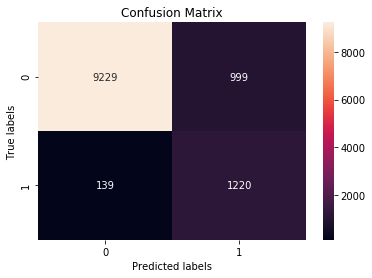

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     20455
           1       0.82      0.76      0.79      2718

    accuracy                           0.95     23173
   macro avg       0.89      0.87      0.88     23173
weighted avg       0.95      0.95      0.95     23173



In [ ]:
batch_size = 128
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=1, validation_split=0.2)

Train on 74152 samples, validate on 18539 samples
Epoch 1/5
 4864/74152 [>.............................] - ETA: 53s - loss: 0.0176 - acc: 0.9932

KeyboardInterrupt: ignored

In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)
cm =confusion_matrix(y_test, predict_class)
print(cm)

[[9934  251]
 [ 470  932]]


In [ ]:
batch_size = 128
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=1, validation_split=0.2)

Train on 147342 samples, validate on 36836 samples
Epoch 1/5
147342/147342 [==============================] - 45s 304us/step - loss: 0.3400 - acc: 0.8464 - val_loss: 0.3222 - val_acc: 0.8488
Epoch 2/5
147342/147342 [==============================] - 43s 292us/step - loss: 0.2405 - acc: 0.8974 - val_loss: 0.1870 - val_acc: 0.9156
Epoch 3/5
147342/147342 [==============================] - 43s 294us/step - loss: 0.2088 - acc: 0.9123 - val_loss: 0.1990 - val_acc: 0.9129
Epoch 4/5
147342/147342 [==============================] - 43s 293us/step - loss: 0.1905 - acc: 0.9208 - val_loss: 0.1171 - val_acc: 0.9510
Epoch 5/5
147342/147342 [==============================] - 43s 293us/step - loss: 0.1712 - acc: 0.9292 - val_loss: 0.1320 - val_acc: 0.9403


In [ ]:
batch_size = 128
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=1, validation_split=0.2)



Train on 147342 samples, validate on 36836 samples
Epoch 1/5
147342/147342 [==============================] - 86s 587us/step - loss: 0.2728 - acc: 0.8781 - val_loss: 0.1312 - val_acc: 0.9457
Epoch 2/5
147342/147342 [==============================] - 81s 552us/step - loss: 0.1603 - acc: 0.9361 - val_loss: 0.1009 - val_acc: 0.9576
Epoch 3/5
147342/147342 [==============================] - 81s 552us/step - loss: 0.1344 - acc: 0.9474 - val_loss: 0.1394 - val_acc: 0.9439
Epoch 4/5
147342/147342 [==============================] - 81s 549us/step - loss: 0.1172 - acc: 0.9542 - val_loss: 0.0884 - val_acc: 0.9622
Epoch 5/5
147342/147342 [==============================] - 81s 551us/step - loss: 0.1055 - acc: 0.9591 - val_loss: 0.0711 - val_acc: 0.9716


In [ ]:
y_pred = model.predict(X_test)
predict_class = np.argmax(y_pred, axis=1)


In [ ]:
cm =confusion_matrix(y_test, predict_class)

In [ ]:
print(cm)

[[9841  344]
 [ 332 1070]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_class))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     10185
           1       0.76      0.76      0.76      1402

    accuracy                           0.94     11587
   macro avg       0.86      0.86      0.86     11587
weighted avg       0.94      0.94      0.94     11587



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
model = Sequential()
model.add(Embedding(num_words,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=sequence_length,
                    trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dropout(0.25))
model.add(Dense(units=2, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 231, 100)          2000100   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 231, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 231, 128)          84992     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41472     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       

In [ ]:
batch_size = 128
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=1, validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 93849 samples, validate on 10428 samples
Epoch 1/5





93849/93849 [==============================] - 52s 551us/step - loss: 0.1895 - acc: 0.9313 - val_loss: 0.1365 - val_acc: 0.9483
Epoch 2/5
93849/93849 [==============================] - 38s 406us/step - loss: 0.1330 - acc: 0.9503 - val_loss: 0.1402 - val_acc: 0.9486
Epoch 3/5
93849/93849 [==============================] - 38s 405us/step - loss: 0.1184 - acc: 0.9550 - val_loss: 0.1259 - val_acc: 0.9530
Epoch 4/5
93849/93849 [==============================] - 38s 408us/step - loss: 0.1074 - acc: 0.9585 - val_loss: 0.1381 - val_acc: 0.9506
Epoch 5/5
93849/93849 [==============================] - 38s 406us/step - loss: 0.0968 - acc: 0.9624 - val_loss: 0.1464 - val_acc: 0.9520


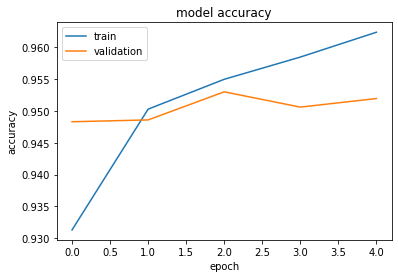

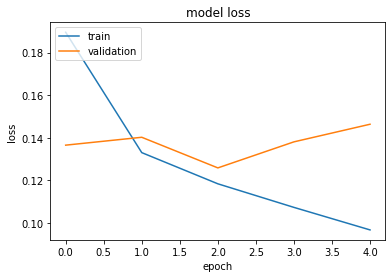

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()